<a href="https://colab.research.google.com/github/netphoenix/ds_belhard/blob/main/ds_hw2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Устанавливаем библиотеку Kaggle
!pip install kaggle -q

In [2]:
from google.colab import drive
import os

In [3]:
# Монтируем Google Диск
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Создаем папку для проекта на Google Диске
!mkdir -p /content/drive/MyDrive/ds_hw2_colab_project

In [5]:
# Указываем путь к токену kaggle на диске
kaggle_json_path_on_drive = '/content/drive/MyDrive/ds_hw2_colab_project/kaggle.json'

# Проверяем, существует ли файл, чтобы избежать ошибок
if not os.path.exists(kaggle_json_path_on_drive):
  print(f"Ошибка: Файл {kaggle_json_path_on_drive} не найден!")
  print("Проверьте что kaggle.json загружен в нужную папку на Google Drive.")
else:
  # Создаем папку .kaggle во временной среде Colab
  !mkdir -p ~/.kaggle
  # Копируем ключ API с Google Drive во временную папку
  !cp {kaggle_json_path_on_drive} ~/.kaggle/
  # Устанавливаем права доступа
  !chmod 600 ~/.kaggle/kaggle.json
  print("Kaggle API успешно настроен с использованием ключа с Google Drive!")

Kaggle API успешно настроен с использованием ключа с Google Drive!


In [6]:
# Создаем файл data_loader.py

%%writefile data_loader.py
import pandas as pd
import os
import subprocess
import zipfile

def download_and_load_from_kaggle(dataset_slug, file_name, data_dir='data'):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    file_path = os.path.join(data_dir, file_name)
    if os.path.exists(file_path):
        print(f"Файл '{file_path}' уже существует. Загружаем его.")
    else:
        print(f"Файл '{file_path}' не найден. Загружаем с Kaggle...")
        command = f"kaggle datasets download -d {dataset_slug} -p {data_dir} --unzip"
        try:
            # Используем флаг --unzip для автоматической распаковки
            result = subprocess.run(command.split(), check=True, capture_output=True, text=True)
            print("Датасет успешно скачан и распакован.")
        except subprocess.CalledProcessError as e:
            print(f"Ошибка при загрузке датасета с Kaggle: {e.stderr}")
            return None
    try:
        df = pd.read_csv(file_path)
        print(f"Данные из '{file_path}' успешно загружены в DataFrame.")
        return df
    except FileNotFoundError:
        print(f"Критическая ошибка: файл '{file_path}' не найден.")
        return None

Writing data_loader.py


In [53]:
# Создаем файл data_processing.py

%%writefile data_processing.py
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def missing_values_report(df):
    """
    Создает и выводит подробный отчет о пропущенных значениях в DataFrame.
    """
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    report = pd.concat([missing_values, missing_percentage], axis=1, keys=['Количество пропусков', 'Процент пропусков, %'])
    # Оставляем только те столбцы, где есть пропуски
    report = report[report['Количество пропусков'] > 0]

    if report.empty:
      print("Пропущенных значений не найдено. Данные чистые!")
    else:
      print("--- Отчет о пропущенных значениях ---")
      print(report)

    return report

def fill_missing_values(df, column, method='mean'):
    """
    Заполняет пропущенные значения в указанном столбце DataFrame.

    Args:
        df (pd.DataFrame): DataFrame для обработки.
        column (str): Название столбца для заполнения.
        method (str): Метод заполнения ('mean', 'median', 'mode').

    Returns:
        pd.DataFrame: DataFrame с заполненными значениями.
    """
    if column not in df.columns:
        print(f"Ошибка: Столбец '{column}' не найден.")
        return df

    if df[column].isnull().sum() == 0:
        print(f"В столбце '{column}' нет пропущенных значений для заполнения.")
        return df

    if method == 'mean':
        # Проверяем, что столбец числовой
        if pd.api.types.is_numeric_dtype(df[column]):
            fill_value = df[column].mean()
        else:
            print(f"Ошибка: Метод 'mean' применим только к числовым столбцам. Столбец '{column}' не является числовым.")
            return df
    elif method == 'median':
        if pd.api.types.is_numeric_dtype(df[column]):
            fill_value = df[column].median()
        else:
            print(f"Ошибка: Метод 'median' применим только к числовым столбцам. Столбец '{column}' не является числовым.")
            return df
    elif method == 'mode':
        fill_value = df[column].mode()[0]
    else:
        print("Ошибка: Неверный метод. Используйте 'mean', 'median' или 'mode'.")
        return df

    df[column].fillna(fill_value, inplace=True)
    print(f"Пропущенные значения в столбце '{column}' были успешно заполнены значением '{fill_value}' (метод: {method}).")
    return df

def encode_features(df):
    """
    Кодирует все столбцы DataFrame из текстовых категорий в числовые.
    """
    encoded_df = df.copy()
    for column in encoded_df.columns:
        encoded_df[column] = LabelEncoder().fit_transform(encoded_df[column])
    print("Все признаки были успешно закодированы в числовой формат.")
    return encoded_df

Overwriting data_processing.py


In [86]:
#Создаем файл visualization.py

%%writefile visualization.py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

visualizations = {}

def add_countplot(df, column, viz_name):
    """ Создает и сохраняет столбчатую диаграмму (countplot). """
    plt.figure(figsize=(6, 4))
    sns.countplot(x=column, data=df, order=df[column].value_counts().index, palette='viridis', hue=column, legend=False)
    plt.title(f'Распределение по признаку: {column}', fontsize=8)
    plt.xlabel(column, fontsize=8)
    plt.ylabel('Количество', fontsize=8)
    plt.xticks(rotation=45)
    visualizations[viz_name] = plt.gcf()
    plt.show()
    print(f"Столбчатая диаграмма '{viz_name}' добавлена.")

def add_histogram(df, column, viz_name, bins=20):
    """ Создает гистограмму для числовых данных. """
    if not pd.api.types.is_numeric_dtype(df[column]):
        print(f"Предупреждение: Гистограмма лучше всего подходит для числовых данных. Столбец '{column}' не является числовым.")

    plt.figure(figsize=(6, 4))
    sns.histplot(df[column], bins=bins, kde=True)
    plt.title(f'Гистограмма распределения для: {column}', fontsize=8)
    plt.xlabel(column, fontsize=8)
    plt.ylabel('Частота', fontsize=8)
    visualizations[viz_name] = plt.gcf()
    plt.show()
    print(f"Гистограмма '{viz_name}' добавлена.")

def add_scatter_plot(df, x_column, y_column, viz_name):
    """ Создает диаграмму рассеяния для поиска связи между двумя числовыми переменными. """
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=x_column, y=y_column, data=df, alpha=0.6)
    plt.title(f'Диаграмма рассеяния: {y_column} vs {x_column}', fontsize=8)
    plt.xlabel(x_column, fontsize=8)
    plt.ylabel(y_column, fontsize=8)
    visualizations[viz_name] = plt.gcf()
    plt.show()
    print(f"Диаграмма рассеяния '{viz_name}' добавлена.")

def add_line_chart(df, x_column, y_column, viz_name):
    """ Создает линейный график, подходит для временных рядов. """
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=x_column, y=y_column, data=df)
    plt.title(f'Линейный график: {y_column} по {x_column}', fontsize=8)
    plt.xlabel(x_column, fontsize=8)
    plt.ylabel(y_column, fontsize=8)
    plt.grid(True)
    visualizations[viz_name] = plt.gcf()
    plt.show()
    print(f"Линейный график '{viz_name}' добавлен.")

def add_heatmap_crosstab(df, x_column, y_column, viz_name):
    """
    Создает тепловую карту на основе таблицы сопряженности для двух категориальных признаков.
    """
    # Создаем таблицу сопряженности (crosstab)
    crosstab = pd.crosstab(df[x_column], df[y_column])

    # Рисуем тепловую карту
    plt.figure(figsize=(8, 6))
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Тепловая карта взаимосвязи: {y_column} vs {x_column}', fontsize=8)
    plt.xlabel(x_column, fontsize=8)
    plt.ylabel(y_column, fontsize=8)
    visualizations[viz_name] = plt.gcf()
    plt.show()
    print(f"Тепловая карта '{viz_name}' добавлена.")


Overwriting visualization.py


In [90]:
# Cell 5: Создаем файл model_training.py

%%writefile model_training.py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def train_and_evaluate(df, target_column):
    """
    Обучает и оценивает модель RandomForestClassifier.
    """
    # Разделение данных на признаки (X) и цель (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Разделение на обучающую и тестовую выборки
    # stratify=y гарантирует одинаковое соотношение классов в обеих выборках
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    print(f"Данные разделены: {len(X_train)} для обучения, {len(X_test)} для теста.")

    # Обучение модели
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    print("\nОбучаем модель RandomForestClassifier...")
    model.fit(X_train, y_train)
    print("Модель успешно обучена.")

    # Предсказание и оценка
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"\nТочность (Accuracy) на тестовых данных: {accuracy:.4f}")

    print("\nОтчет о классификации:")
    # 'e' -> 0 (съедобный), 'p' -> 1 (ядовитый) после кодирования
    print(classification_report(y_test, predictions, target_names=['Съедобный (e)', 'Ядовитый (p)']))

    print("\nМатрица ошибок (Confusion Matrix):")
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Съедобный', 'Ядовитый'], yticklabels=['Съедобный', 'Ядовитый'])
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.show()

    return model

Overwriting model_training.py


In [87]:
import importlib # Импортируем библиотеку для перезагрузки

# Импортируем наши модули как обычно
import data_loader
import data_processing
import visualization
import model_training

# Принудительно перезагружаем их, чтобы учесть последние изменения из %%writefile
importlib.reload(data_loader)
importlib.reload(data_processing)
importlib.reload(visualization)
importlib.reload(model_training)

<module 'model_training' from '/content/model_training.py'>

In [34]:
# Загрузка данных
# https://www.kaggle.com/datasets/uciml/mushroom-classification
df = data_loader.download_and_load_from_kaggle('uciml/mushroom-classification', 'mushrooms.csv')

Файл 'data/mushrooms.csv' уже существует. Загружаем его.
Данные из 'data/mushrooms.csv' успешно загружены в DataFrame.


In [ ]:
print("Первые 5 строк датасета:")
print(df.head())
print(f"\nРазмер датасета: {df.shape}")

In [56]:
print("\nАнализ пропущенных значений")
data_processing.missing_values_report(df)


Анализ пропущенных значений
Пропущенных значений не найдено. Данные чистые!


,Количество пропусков,"Процент пропусков, %"


In [57]:
# В этом датасете нет пропусков, но если бы они были например в столбце 'stalk-root',
# можно использовать метод 'mode' (самое частое значение).
data_processing.fill_missing_values(df, 'stalk-root', method='mode')

В столбце 'stalk-root' нет пропущенных значений для заполнения.


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [59]:
# Предобработка: кодирование признаков для дальнейшей визуализации
encoded_df = data_processing.encode_features(df)
encoded_df.head()

Все признаки были успешно закодированы в числовой формат.


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


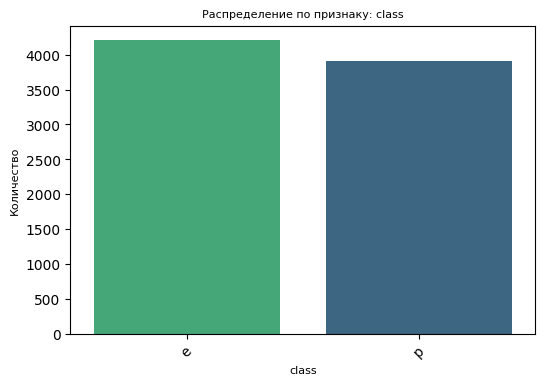

Столбчатая диаграмма 'class_distribution' добавлена.

Столбчатая диаграмма для признака 'odor':


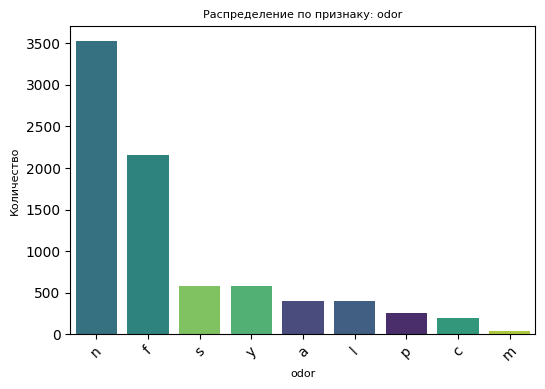

Столбчатая диаграмма 'odor_countplot' добавлена.

Гистограмма для закодированного признака 'cap-color':


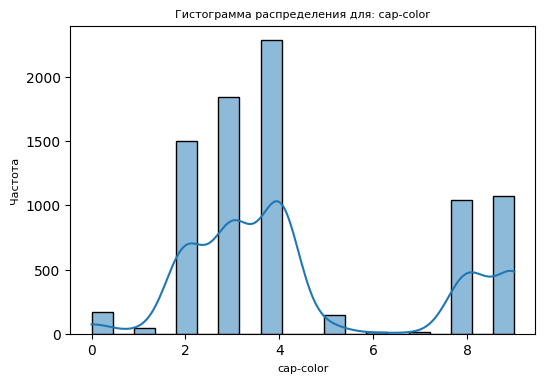

Гистограмма 'cap_color_hist' добавлена.

Тепловая карта для поиска связи между 'cap-color' и 'gill-color':


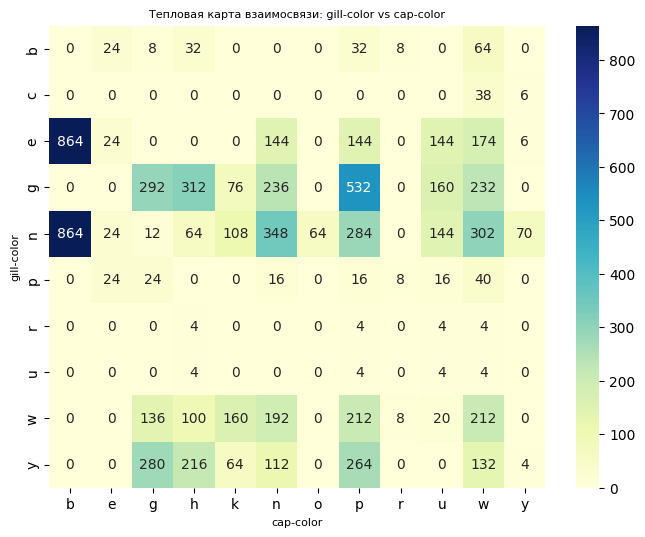

Тепловая карта 'color_heatmap' добавлена.

Линейный график (демонстрационный): средний 'ring-number' для каждого 'odor':


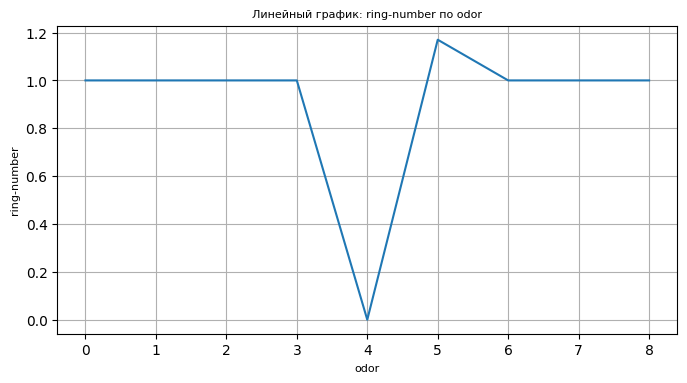

Линейный график 'odor_ring_line' добавлен.


In [88]:
# Визуализируем

# Count Plot (Столбчатая диаграмма) для категориальных данных
# 'e' = edible (съедобный), 'p' = poisonous (ядовитый)
visualization.add_countplot(df, 'class', 'class_distribution')
# распределение запахов (odor) в исходном датасете
print("\nСтолбчатая диаграмма для признака 'odor':")
visualization.add_countplot(df, 'odor', 'odor_countplot')

# Histogram (Гистограмма) для числовых (закодированных) данных
# распределение закодированных значений для цвета шляпки
print("\nГистограмма для закодированного признака 'cap-color':")
visualization.add_histogram(encoded_df, 'cap-color', 'cap_color_hist')

# диаграмма рассеяния идеально подходит для поиска связи между двумя непрерывными числовыми переменными.
# в датасете с грибами все переменные по своей природе являются категориальными и получается полная ерунда
# Scatter Plot (Диаграмма рассеяния) для поиска взаимосвязей
# связь между цветом шляпки и цветом жабр (после кодирования)
# print("\nДиаграмма рассеяния для 'gill-color' vs 'cap-color':")
# visualization.add_scatter_plot(encoded_df, 'cap-color', 'gill-color', 'color_scatter')

print("\nТепловая карта для поиска связи между 'cap-color' и 'gill-color':")
visualization.add_heatmap_crosstab(df, 'cap-color', 'gill-color', 'color_heatmap')

# Line Chart (Линейный график)
# Этот тип графика не очень подходит для данного датасета, так как у нас нет временных рядов.
# можем попробовать сгруппировать данные и построить график
# Например, средний размер кольца (ring-number) для каждого типа запаха (odor).
grouped_data = encoded_df.groupby('odor')['ring-number'].mean().reset_index()
print("\nЛинейный график (демонстрационный): средний 'ring-number' для каждого 'odor':")
visualization.add_line_chart(grouped_data, 'odor', 'ring-number', 'odor_ring_line')



Обучение модели
Данные разделены: 6093 для обучения, 2031 для теста.

Обучаем модель RandomForestClassifier...
Модель успешно обучена.

Точность (Accuracy) на тестовых данных: 1.0000

Отчет о классификации:
               precision    recall  f1-score   support

Съедобный (e)       1.00      1.00      1.00      1052
 Ядовитый (p)       1.00      1.00      1.00       979

     accuracy                           1.00      2031
    macro avg       1.00      1.00      1.00      2031
 weighted avg       1.00      1.00      1.00      2031


Матрица ошибок (Confusion Matrix):


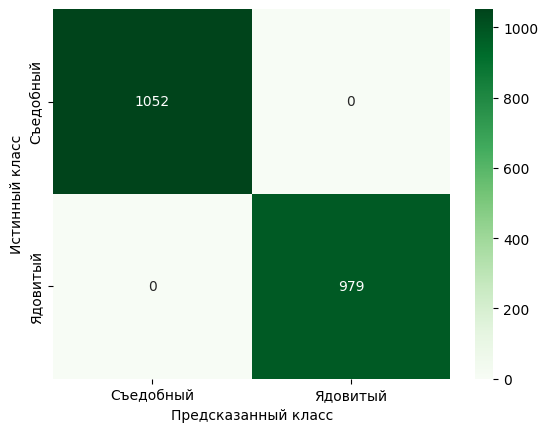

In [91]:
    print("\nОбучение модели")
    model = model_training.train_and_evaluate(encoded_df, 'class')